In [1]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from scipy import io
import numpy as np
import pycroscopy as px
import matplotlib.pyplot as plt
from os.path import join as pjoin
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
import os
from os.path import join as pjoin
from keras.regularizers import l1
import sys
import glob

% matplotlib inline

Using TensorFlow backend.


In [2]:
def get_ith_layer_output(model, X, i, mode='test'):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
    return layer_output

In [3]:
mods = keras.models.load_model("./try2/weights.139-0.82.hdf5")

In [4]:
mods.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_5 (I

In [5]:
for i,l in enumerate(mods.layers):
    print(i,l)

0 <keras.engine.topology.InputLayer object at 0x00000237EE07B940>
1 <keras.engine.topology.InputLayer object at 0x00000237BD8B60F0>
2 <keras.engine.topology.InputLayer object at 0x00000237EE07BE10>
3 <keras.engine.topology.InputLayer object at 0x00000237EE07B9B0>
4 <keras.engine.topology.InputLayer object at 0x00000237EE07BEB8>
5 <keras.engine.topology.InputLayer object at 0x00000237EE089CF8>
6 <keras.engine.topology.InputLayer object at 0x00000237EE07BDA0>
7 <keras.engine.topology.InputLayer object at 0x00000237EE07BC50>
8 <keras.layers.wrappers.Bidirectional object at 0x00000237EE04CA20>
9 <keras.layers.wrappers.Bidirectional object at 0x00000237EE04CC18>
10 <keras.layers.wrappers.Bidirectional object at 0x00000237EE04CDD8>
11 <keras.layers.wrappers.Bidirectional object at 0x00000237EE04CF98>
12 <keras.layers.wrappers.Bidirectional object at 0x00000237EE042390>
13 <keras.layers.wrappers.Bidirectional object at 0x00000237EE042668>
14 <keras.layers.wrappers.Bidirectional object at 0x00

In [12]:
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import sys
import os
import math

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display

# Finally, pycroscopy itself
import pycroscopy as px

from os.path import join as pjoin

# set up notebook to show plots within the notebook
% matplotlib inline

import glob


In [13]:
 input_file_path ='D:/PZT001_BEPs_0003.h5' #px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                         #filter='Translated file (*.h5);; \\ Parameters for raw BE data (*.txt *.mat *xls *.xlsx)')

(data_dir, data_name) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
print('Working on:\n' + h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]

File is already Pycroscopy ready.
Working on:
D:/PZT001_BEPs_0003.h5


In [14]:
h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores)
    h5_sho_fit = sho_fitter.do_fit(processors=max_cores)
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    try:
        h5_sho_fit = h5_sho_group[-1]['Fit']
    except KeyError:
        print('Previously computed guess found. Now computing fit')
        h5_sho_fit = sho_fitter.do_fit(processors=max_cores, h5_guess=h5_sho_guess)

Taking previous SHO results already present in file


In [15]:
(Nd_mat, success) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit)
print('Reshape Success = ' + str(success))
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

# phase_offset = 0;

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset

Reshape Success = True
Nd_mat shape =  (80, 80, 128, 2, 3)
Phase offset [rad] =  0.342565


In [16]:
def norm(indat):
    indat-=np.mean(indat)
    indat/=np.std(indat)
    return indat

In [59]:
amp_off = np.atleast_3d(norm(Nd_mat["Amplitude [V]"][:,:,:,1,2].reshape(-1,128)))
phase_off = np.atleast_3d(norm(Nd_mat["Phase [rad]"][:,:,:,1,2].reshape(-1,128)))
freq_off = np.atleast_3d(norm(Nd_mat["Frequency [Hz]"][:,:,:,1,2].reshape(-1,128)))
qf_off = np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,1,2].reshape(-1,128))

amp_on = np.atleast_3d(norm(Nd_mat["Amplitude [V]"][:,:,:,0,2].reshape(-1,128)))
phase_on = np.atleast_3d(norm(Nd_mat["Phase [rad]"][:,:,:,0,2].reshape(-1,128)))
freq_on = np.atleast_3d(norm(Nd_mat["Frequency [Hz]"][:,:,:,0,2].reshape(-1,128)))
qf_on= np.atleast_3d(norm(Nd_mat["Quality Factor"][:,:,:,0,2].reshape(-1,128)))

In [18]:
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


In [26]:
out = np.zeros((6400, 64))
from keras import backend as K
activations = get_activations(mods, [amp_off,phase_off,freq_off,qf_off,
                                     amp_on, phase_on, freq_on, qf_on])

----- activations -----


InternalError: Blas GEMM launch failed : a.shape=(6400, 128), b.shape=(128, 128), m=6400, n=128, k=128
	 [[Node: bidirectional_1_1/while/MatMul_4 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](bidirectional_1_1/while/Identity_2, bidirectional_1_1/while/MatMul_4/Enter)]]
	 [[Node: bidirectional_1_1/concat/_7391 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_582_bidirectional_1_1/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'bidirectional_1_1/while/MatMul_4', defined at:
  File "C:\Users\Josh_\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Josh_\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-07f6f0926891>", line 1, in <module>
    mods = keras.models.load_model("./try2/weights.139-0.82.hdf5")
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2500, in from_config
    process_node(layer, node_data)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2457, in process_node
    layer(input_tensors[0], **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\wrappers.py", line 290, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 2023, in call
    initial_state=initial_state)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 589, in call
    input_length=timesteps)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2646, in rnn
    swap_memory=True)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2775, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2604, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2554, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2632, in _step
    tuple(constants))
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 580, in step
    return self.cell.call(inputs, states, **kwargs)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 1836, in call
    self.recurrent_kernel_i))
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1057, in dot
    out = tf.matmul(x, y)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Josh_\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(6400, 128), b.shape=(128, 128), m=6400, n=128, k=128
	 [[Node: bidirectional_1_1/while/MatMul_4 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](bidirectional_1_1/while/Identity_2, bidirectional_1_1/while/MatMul_4/Enter)]]
	 [[Node: bidirectional_1_1/concat/_7391 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_582_bidirectional_1_1/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [27]:
t = mods.predict([amp_off,phase_off,freq_off,qf_off,
                                     amp_on, phase_on, freq_on, qf_on], batch_size = 128)

In [33]:
v = np.asarray(t)

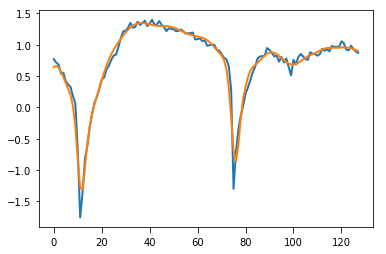

In [40]:
plt.plot(amp_off[200,:,0])
plt.plot(v[0,200,:,0])

In [19]:
mod_hold = mods

In [25]:
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()
mods.layers.pop()

In [36]:
mods.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_5 (I

C:\Users\Josh_\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [41]:
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=mod_hold.input,
                                 outputs=mod_hold.get_layer(layer_name).output)

In [43]:
intermediate_output = intermediate_layer_model.predict([amp_off,phase_off,freq_off,qf_off,
                                     amp_on, phase_on, freq_on, qf_on], batch_size = 128)

In [42]:
intermediate_layer_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
input_5 (I

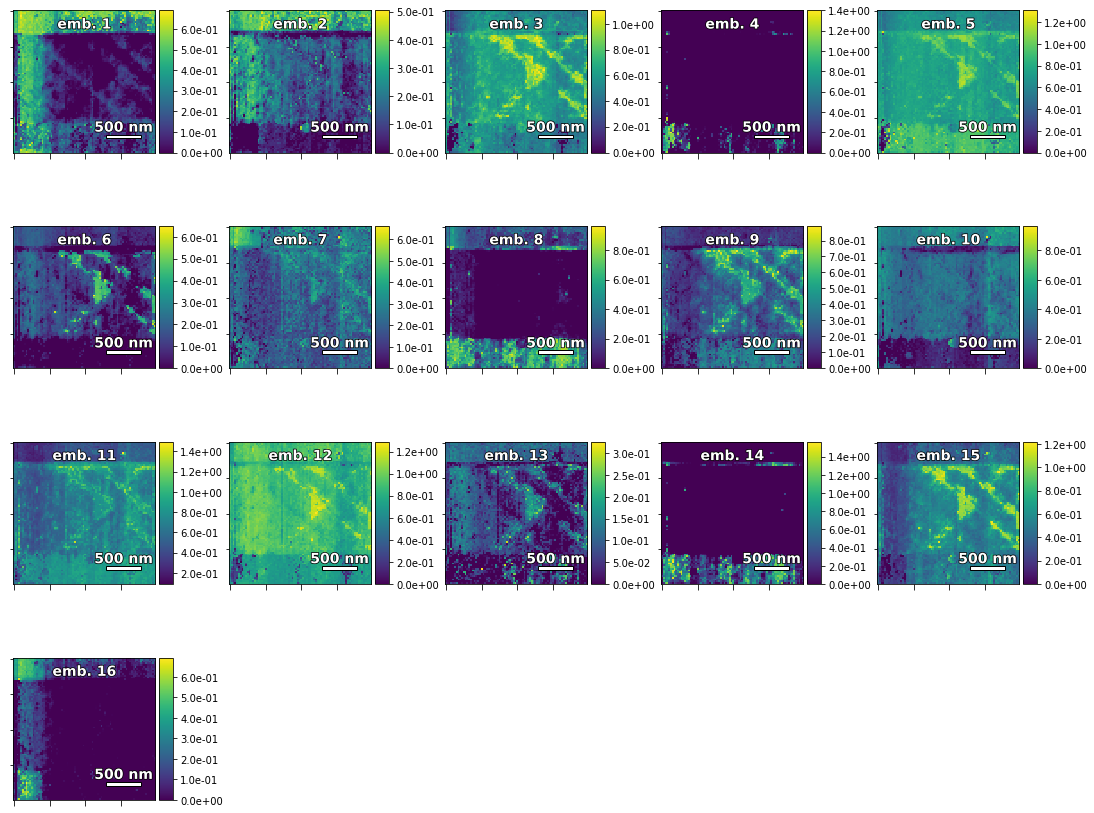

In [50]:
import plotting_codes_Josh as plt_p

plt_p.plot_embedding_maps(intermediate_output[:,0:16],
                 add_scalebar=[2000,500],
                 filename='./embedding_maps_1')

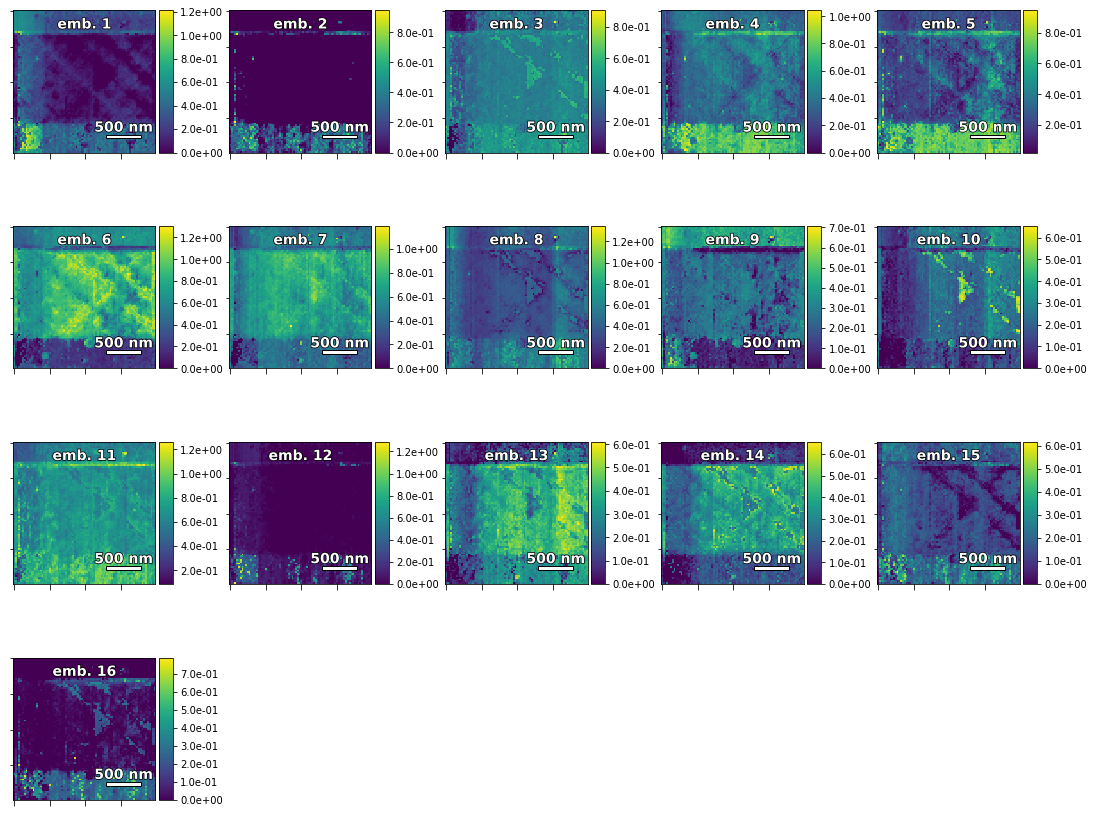

In [51]:
import plotting_codes_Josh as plt_p

plt_p.plot_embedding_maps(intermediate_output[:,16:32],
                 add_scalebar=[2000,500],
                 filename='./embedding_maps_1')

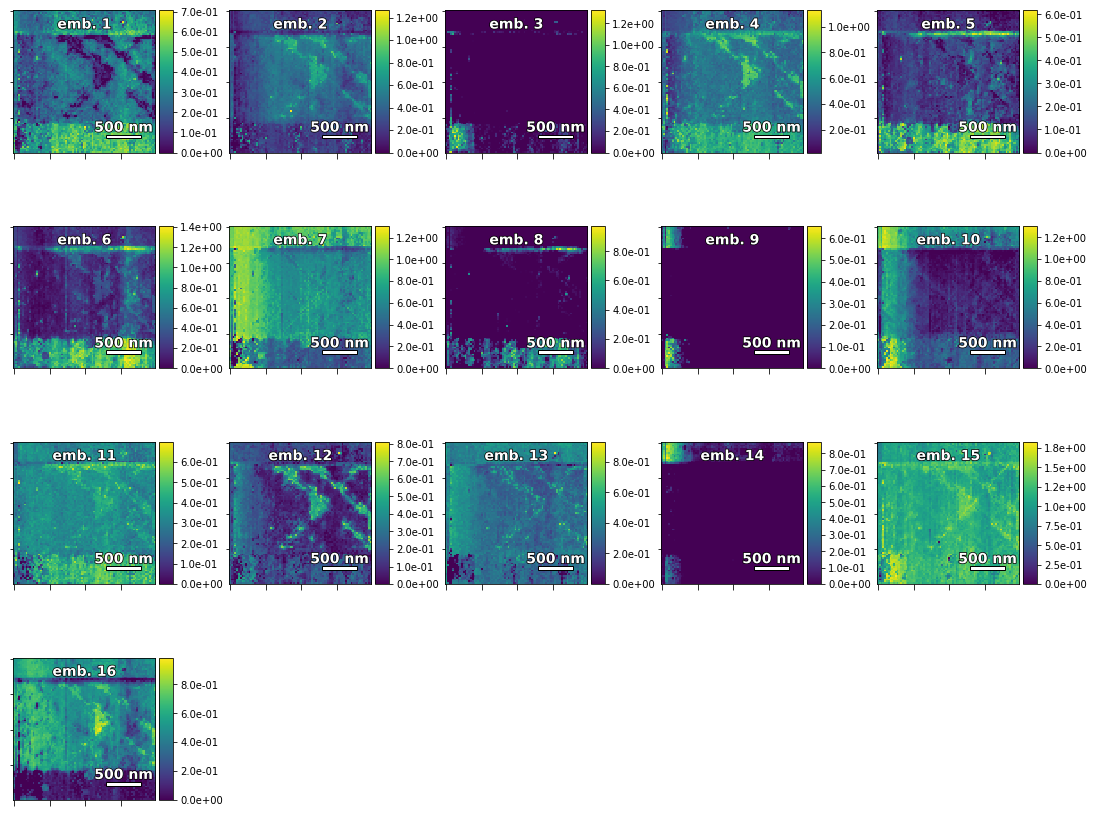

In [52]:
import plotting_codes_Josh as plt_p

plt_p.plot_embedding_maps(intermediate_output[:,32:48],
                 add_scalebar=[2000,500],
                 filename='./embedding_maps_1')

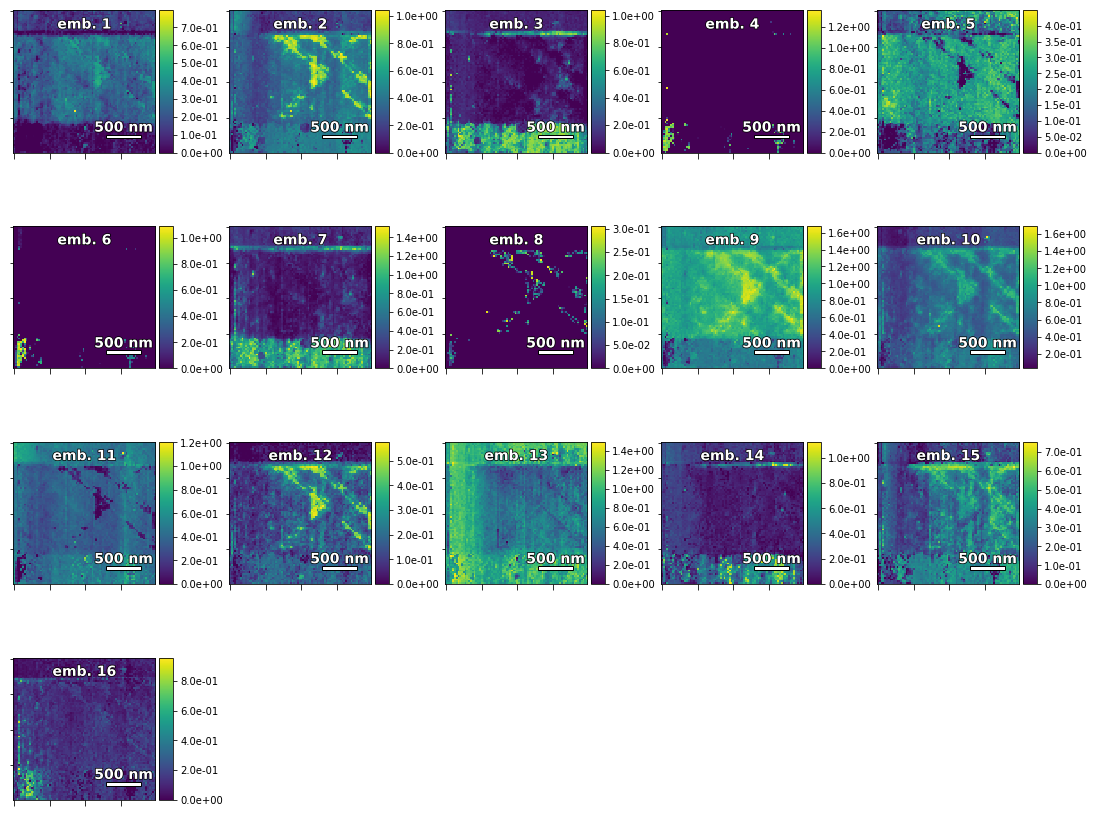

In [53]:
import plotting_codes_Josh as plt_p

plt_p.plot_embedding_maps(intermediate_output[:,48:64],
                 add_scalebar=[2000,500],
                 filename='./embedding_maps_1')

In [47]:
np.save('out', intermediate_output)

In [ ]:
plt.hist(qf_on.reshape(-1),100)
#plt.plt(np.hist(phase_off))
#plt.plt(np.hist(freq_off)) 
#plt.plt(np.hist(qf_off = np
#plt.plt(np.hist(amp_on))
#plt.plt(phase_on = 
#plt.plt(freq_on = n
#plt.plt(qf_on= np.a

In [55]:
amp_off.shape

(6400, 128, 1)